✅ DQN: 데이터 로드 및 이동 평균 적용 완료. (총 10 에피소드)
✅ Double_DQN: 데이터 로드 및 이동 평균 적용 완료. (총 10 에피소드)
✅ Dueling_DQN: 데이터 로드 및 이동 평균 적용 완료. (총 10 에피소드)
✅ PPO: 데이터 로드 및 이동 평균 적용 완료. (총 10 에피소드)
✅ A2C: 데이터 로드 및 이동 평균 적용 완료. (총 10 에피소드)


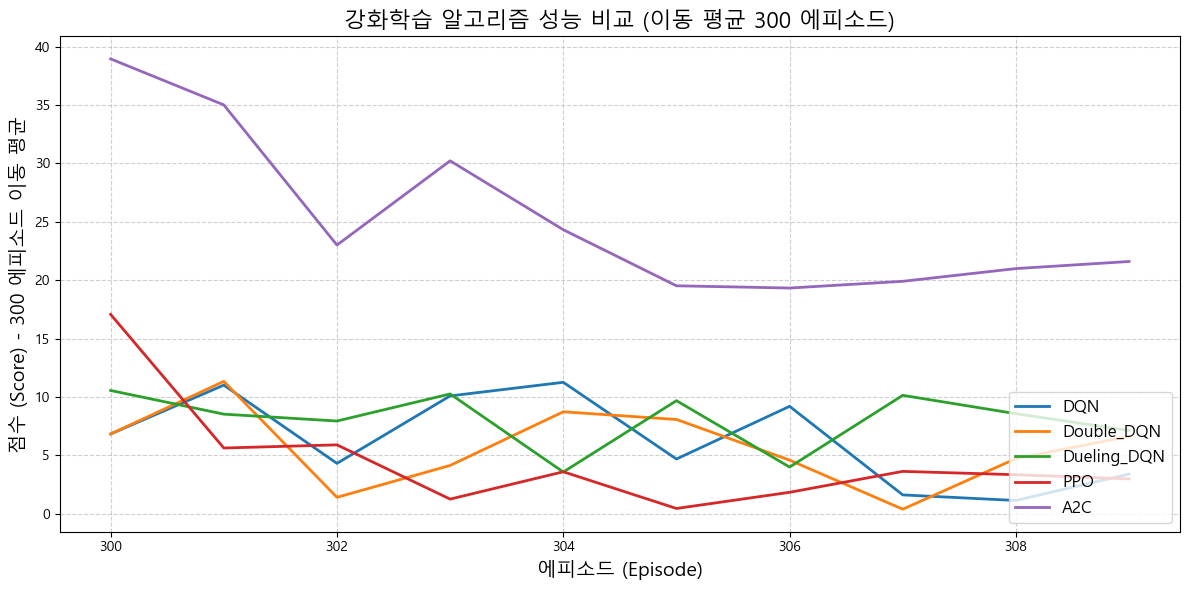

In [5]:
import numpy as np
import matplotlib.pyplot as plt

# --- 설정 변수 ---
ALGORITHMS = ["DQN", "Double_DQN", "Dueling_DQN", "PPO", "A2C"]
WINDOW_SIZE = 100  # 이동 평균을 계산할 윈도우 크기 (객관성 있는 추세 파악을 위해 중요)
FIG_SIZE = (12, 6)
loaded_scores = []

gamma = 0
learning_rate = 0

def load_and_plot_scores(algorithms, window_size, fig_size):
    """
    각 알고리즘의 scores.npy 파일을 불러와 학습 곡선 그래프를 생성합니다.
    """
    # 5가지 알고리즘의 학습 곡선을 그립니다.
    plt.figure(figsize=fig_size)
    plt.title(f"강화학습 알고리즘 성능 비교 (이동 평균 {window_size} 에피소드)", fontsize=16)
    plt.xlabel("에피소드 (Episode)", fontsize=14)
    plt.ylabel(f"점수 (Score) - {window_size} 에피소드 이동 평균", fontsize=14)
    plt.grid(True, linestyle='--', alpha=0.6)
    for algo in algorithms:
        file_name = f"./scores/{algo}_scores.npy"
        
        try:
            
            # 1. 점수 데이터 불러오기
            scores = np.load(file_name)
            loaded_scores.append(scores)
            scores = np.mean(scores, axis = 0)
            

            # 2. 이동 평균 계산 함수 정의 및 적용
            def moving_average(data, window):
                """데이터에 이동 평균을 적용하여 평활화합니다."""
                if len(data) < window:
                    # 데이터가 윈도우 크기보다 작으면 원본 반환
                    return data
                
                # convolution을 이용한 효율적인 이동 평균 계산
                weights = np.ones(window) / window
                smoothed_data = np.convolve(data, weights, 'valid')
                
                # 시작점 맞추기: valid 모드는 윈도우 크기만큼 길이가 줄어들므로, 
                # 시작 부분을 채우거나 (간단히) 뒤쪽부터 플롯합니다.
                return smoothed_data
            
            smoothed_scores = moving_average(scores, window_size)
            
            # 3. 그래프에 추가
            # 이동 평균이 적용된 후의 길이에 맞춰 X축 생성
            x_axis = np.arange(len(smoothed_scores)) + window_size
            
            plt.plot(x_axis, smoothed_scores, label=f"{algo}", linewidth=2)
            
            
            print(f"✅ {algo}: 데이터 로드 및 이동 평균 적용 완료. (총 {len(scores)} 에피소드)")

        except FileNotFoundError:
            print(f"❌ 오류: {file_name} 파일을 찾을 수 없습니다. 이 알고리즘은 건너뜁니다.")
        except Exception as e:
            print(f"❌ 오류 발생 중 {algo}: {e}")

   # 4. 그래프 설정 마무리
    plt.legend(loc="lower right", fontsize=12)
    plt.tight_layout()
    plt.show()


# --- 함수 실행 ---
plt.rcParams['font.family'] ='Malgun Gothic'
plt.rcParams['axes.unicode_minus'] =False`
load_and_plot_scores(ALGORITHMS, 300, FIG_SIZE)

In [7]:
# evaluate.py
import os
import glob
import math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_theme(style="whitegrid", palette="pastel")

# 사용자가 정의한 알고리즘 목록
ALGORITHMS = ["DQN", "Double_DQN", "Dueling_DQN", "PPO", "A2C"]
WINDOW_SIZE = 100 # 이동 평균 윈도우 크기 (선택 사항)

def load_results(algorithms):
    """
    {알고리즘명}_scores.npy 파일을 불러와 DataFrame으로 변환합니다.
    데이터 형태: (Seed_count, Episode_count)
    """
    dfs = []
    
    for alg in algorithms:
        file_name = f"./scores/{alg}_scores.npy"
        
        try:
            # 1. NumPy 데이터 불러오기: shape (5, 3000)
            data = np.load(file_name)
            
            # 2. DataFrame 변환을 위한 준비
            seed_count, episode_count = data.shape
            
            # 3. 데이터프레임으로 변환 (롱 폼)
            df = pd.DataFrame(data.T, columns=[f"Seed_{i}" for i in range(seed_count)])
            df.index.name = "Episode"
            df = df.reset_index()
            
            # 4. Episode, Seed, Score 컬럼으로 melt
            df_long = df.melt(id_vars=["Episode"], 
                              var_name="Seed", 
                              value_name="Score")
            
            # 5. 알고리즘 컬럼 추가
            df_long["Algorithm"] = alg
            
            dfs.append(df_long)
            print(f"✅ {alg}: {seed_count} seeds, {episode_count} episodes 데이터 로드 완료.")
            
        except FileNotFoundError:
            print(f"❌ 오류: {file_name} 파일을 찾을 수 없습니다. 이 알고리즘은 건너뜁니다.")
        except Exception as e:
            print(f"❌ 오류 발생 중 {alg}: {e}")

    if not dfs:
        raise FileNotFoundError("모든 알고리즘 파일 로드 실패.")
        
    results = pd.concat(dfs, ignore_index=True)
    return results

def summarize_by_algorithm(df):
    """
    각 알고리즘의 최종 에피소드(3000번째)의 Score만 추출하여 요약 통계 계산
    """
    # 최종 에피소드만 필터링 (Episode 0부터 시작한다고 가정할 경우)
    final_episode = df["Episode"].max()
    final_scores = df[df["Episode"] == final_episode]
    
    # 이 시점에서는 Seed별 최종 점수만 남음
    group = final_scores.groupby("Algorithm")["Score"].agg(["mean", "std", "count"])
    group = group.rename(columns={"mean": "mean_score", "std": "std_score", "count": "n"})
    
    # 통계 계산
    group["sem"] = group["std_score"] / np.sqrt(group["n"])
    group["ci_low"] = group["mean_score"] - 1.96 * group["sem"]
    group["ci_high"] = group["mean_score"] + 1.96 * group["sem"]
    
    return group.reset_index()

def plot_bar_ci(summary_df, out_dir="plots"):
    """
    알고리즘별 최종 평균 보상 + 95% CI를 바 차트로 그려 PNG/SVG로 저장
    """
    os.makedirs(out_dir, exist_ok=True)
    plt.figure(figsize=(8, 5))
    ax = plt.gca()
    
    # ⚠️ 수정된 부분: hue='Algorithm' 추가 및 legend=False로 설정
    sns.barplot(data=summary_df, 
                x="Algorithm", 
                y="mean_score", 
                hue="Algorithm", # X축과 동일한 변수를 hue에 할당
                yerr=0, 
                ax=ax,
                palette="pastel", 
                legend=False, # 경고 해결을 위해 범례 숨김
                capsize=0.1)
    
    # 95% CI를 error bar로 추가 (이 부분은 동일)
    ax.errorbar(summary_df["Algorithm"],
                summary_df["mean_score"],
                yerr=1.96 * summary_df["sem"],
                fmt='none', c='black', capsize=5)
                
    plt.title(f"Algorithm Final Performance Comparison (Episode {summary_df['n'].iloc[0]})")
    plt.ylabel("Mean Score (Final Episode)")
    plt.xlabel("Algorithm")
    plt.tight_layout()
    plt.savefig(os.path.join(out_dir, "algo_final_mean_ci.png"), dpi=300)
    plt.savefig(os.path.join(out_dir, "algo_final_mean_ci.svg"), format="svg")
    plt.close()

DOWNSAMPLE_RATE = 10 # 10 에피소드마다 하나의 데이터 포인트만 시각화

def plot_learning_curves_robust(df, out_dir="plots"):
    """
    Episode-wise Score를 다운샘플링 및 선처리 후 시각화하여 멈춤 문제를 해결합니다.
    df에 columns: Episode, Score, Algorithm, Seed
    """
    if "Episode" not in df.columns:
        return
        
    os.makedirs(out_dir, exist_ok=True)

    # 1. 데이터 다운샘플링 (처리할 데이터 양을 10배 감소)
    # Episode가 10의 배수인 데이터만 추출합니다.
    df_sampled = df[df['Episode'] % DOWNSAMPLE_RATE == 0].copy()

    # 2. Pandas를 이용한 통계량 선처리 (Pre-aggregation)
    # Episode와 Algorithm별로 5개 Seed의 평균과 표준오차(SEM)를 미리 계산합니다.
    summary_df = df_sampled.groupby(['Episode', 'Algorithm'])['Score'].agg(
        ['mean', 'std', 'count']
    ).reset_index()
    summary_df = summary_df.rename(columns={'mean': 'Mean_Score', 'std': 'Std_Score', 'count': 'N'})
    
    # 표준 오차(SEM) 계산
    summary_df['SEM'] = summary_df['Std_Score'] / np.sqrt(summary_df['N'])
    # 95% CI 경계 계산
    summary_df['CI_High'] = summary_df['Mean_Score'] + 1.96 * summary_df['SEM']
    summary_df['CI_Low'] = summary_df['Mean_Score'] - 1.96 * summary_df['SEM']
    
    # 3. 시각화 (Matplotlib 기본 기능 활용)
    plt.figure(figsize=(10, 6))
    ax = plt.gca()
    
    algorithms = summary_df['Algorithm'].unique()
    palette = sns.color_palette("pastel", len(algorithms))

    for i, alg in enumerate(algorithms):
        subset = summary_df[summary_df['Algorithm'] == alg]
        
        # 1) 평균 선 그리기
        ax.plot(subset['Episode'], subset['Mean_Score'], 
                label=alg, 
                color=palette[i], 
                linewidth=2)
        
        # 2) 신뢰 구간(CI) 음영 채우기
        ax.fill_between(subset['Episode'], 
                        subset['CI_Low'], 
                        subset['CI_High'], 
                        color=palette[i], 
                        alpha=0.3, 
                        label=None) # 범례에 중복 표시되지 않도록 None 설정
    
    plt.title(f"Learning Curves (Mean $\pm$ 95% CI, Sampled Every {DOWNSAMPLE_RATE} Episodes)")
    plt.xlabel("Episode")
    plt.ylabel("Score")
    plt.legend(loc="lower right")
    plt.grid(True, linestyle='--', alpha=0.6)
    plt.tight_layout()
    
    plt.savefig(os.path.join(out_dir, "learning_curves_robust.png"), dpi=300)
    plt.savefig(os.path.join(out_dir, "learning_curves_robust.svg"), format="svg")
    plt.close()
    
def save_results_csv(results_df, path="results_combined.csv"):
    os.makedirs(os.path.dirname(path) or ".", exist_ok=True)
    # 전체 롱폼 데이터를 CSV로 저장하여 추가 분석에 활용
    results_df.to_csv(path, index=False)
    print(f" Combined full results (long-form) saved to {path}")

def main():
    # .npy 파일에서 데이터를 로드하고 DataFrame으로 변환
    results = load_results(ALGORITHMS)

    # 1. 최종 에피소드 점수를 기반으로 통계 요약
    summary = summarize_by_algorithm(results)

    # 2. 결과 저장
    save_results_csv(results, path="results_combined_long.csv")
    summary.to_csv("summary_final_scores.csv", index=False)
    print(" Summary of final scores saved to summary_final_scores.csv")

    # 3. 시각화
    plot_bar_ci(summary, out_dir="plots") # 최종 성능 막대 그래프
    print("completed plot bar ci graph.")
    plot_learning_curves_robust(results, out_dir="plots") # 학습 곡선 (평균 + CI)
    print("completed learning curve graphs")

if __name__ == "__main__":
    main()

✅ DQN: 5 seeds, 10 episodes 데이터 로드 완료.
✅ Double_DQN: 5 seeds, 10 episodes 데이터 로드 완료.
✅ Dueling_DQN: 5 seeds, 10 episodes 데이터 로드 완료.
✅ PPO: 5 seeds, 10 episodes 데이터 로드 완료.
✅ A2C: 5 seeds, 10 episodes 데이터 로드 완료.
 Combined full results (long-form) saved to results_combined_long.csv
 Summary of final scores saved to summary_final_scores.csv
completed plot bar ci graph.
completed learning curve graphs
